In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import anndata as ad
import csv
import gpzoo.pri_experiment_utilities as putil
import matplotlib.pyplot as plt
import numpy as np
import random
import scanpy as sc
import scipy.sparse as sparse
import squidpy as sq
import tensorflow as tf
import time
import torch
import torch.nn.utils as nn_utils

from anndata import AnnData
from contextlib import suppress
from copy import deepcopy
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import (add_jitter, anndata_to_train_val, deviancePoisson, dims_autocorr, regularized_nmf, rescale_spatial_coords, scanpy_sizefactors)
from os import path
from scanpy import read_h5ad
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import ParameterGrid, KFold, train_test_split
from squidpy.gr import spatial_autocorr, spatial_neighbors
from tensorflow import constant
from tensorflow.data import Dataset
from torch import distributions, nn, optim
from tqdm import tqdm

2024-10-04 16:36:46.706133: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 16:36:46.725510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 16:36:46.754543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 16:36:46.754572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 16:36:46.771568: I tensorflow/core/platform/cpu_feature_gua

In [3]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/vnngp/'
save_path = path.join(root_path, 'results/visium/nnnsfh')

In [6]:
save_path

'/engelhardt/home/pshrestha/vnngp/results/visium/nnnsfh'

In [7]:
X, Y = putil.load_visium()
Y = Y.T

In [8]:
Y.shape

(2688, 11925)

## Pipeline

In [32]:
def run_experiment(X, Y, save_path, batched=True):
    # Define the parameter grid
    param_grid = {
        'sigma': [0.1],
        'lengthscale': [0.07],
        'learning_rate': [0.0001],
        'L': [5, 10, 15],
        'M': [50, 1000, 2000, len(X)],
        'K': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000]
    }
    
    # Iterate over each parameter combination
    for params in ParameterGrid(param_grid):
        kwargs = {
                    'L': params['L'], 
                    'M': params['M'], # use total number of inducing points
                    'sigma': params['sigma'], 
                    'lengthscale': params['lengthscale'], 
                    'jtr': 1e-2, # no lower
                    'batch_size': 128,
                    'lr': params['learning_rate'],
                    'rs': 256,
                    'lkzz_build': 1,
                    'model': 'VNNGP',
                    'L1_jitter': 1e-1, # no lower
                    'iterations': params['iterations'],
                    'K': params['K'],
            }
    
        # load in factors and loadings
        nmf_save_path = path.join(root_path, 'results/visium/nmf/')
        factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={kwargs['L']}.npy")
        loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={kwargs['L']}.npy")
        factors = np.load(factors_path)
        loadings = np.load(loadings_path)
    
        file_path = kwargs['model']
        if kwargs['model'] == 'VNNGP':
            file_path += f"_K={kwargs['K']}"
        file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}"

            
        if batched:
            file_path += f"_bs={kwargs['batch_size']}"
            
        file_path += f"_NMFinit"
        X_array = np.array(X)
        Y_array = np.array(Y)
        moran_idx, moranI = putil.dims_autocorr(factors, X_array)
        factors = factors[:, moran_idx]
        loadings = loadings[:, moran_idx]

        # check of model and its state dictionary already exist
        model_state_path = f'{save_path}/{file_path}_state_dict.pth'
        model_info_path = f'{save_path}/{file_path}_model.pt'

        if path.exists(model_state_path) and path.exists(model_info_path):
            print(f"{model_state_path} already exists.")
            continue
 
        else:
            print(f"Training a new model and saving to {model_state_path}.")
            model = putil.build_model_hybrid(X_array, Y_array, loadings=loadings, factors=factors, kwargs=kwargs)
            losses, means, scales, final_time = [], [], [], 0
    
        putil.model_grads_hybrid(model)
        model.sf.prior.jitter = kwargs['jtr']
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
        model.to(device)
        X_torch = torch.tensor(X).type(torch.float).to(device)
        Y_torch = torch.tensor(Y).type(torch.float).to(device)
    
        start_time = time.time()
        more_losses, more_means, more_scales, idxs = putil.train_hybrid_batched(model, optimizer, X_torch, Y_torch, device, 
                                                                         steps=kwargs['iterations'], E=3, batch_size=kwargs['batch_size'],
                                                                         kwargs=kwargs)
        end_time = time.time()
        final_time += (end_time - start_time)

        # combine new and previous losses, means, scales
        losses.extend(more_losses)
        means.extend(more_means)
        scales.extend(more_scales)

        torch.save(model.state_dict(), model_state_path)
        torch.save({
                'losses': losses,
                'means': means,
                'scales': scales,
                'time': final_time
        }, model_info_path)
    
        with torch.no_grad():
            X_torch = torch.tensor(X).type(torch.float)
            Y_torch = torch.tensor(Y).type(torch.float)
            val_loss = putil.evaluate_model_hybrid(model, X_torch.cpu(), Y_torch, device, kwargs=kwargs)
            
        mean_cv_loss = np.mean(val_loss)
        print(f'Params: {params}, Mean CV Loss: {mean_cv_loss}')
    
        #write the results to the CSV file
        #writer.writerow([params['iterations'], params['learning_rate'], params['sigma'], params['lengthscale'], final_time, mean_cv_loss])
    
        fig1, ax1 = plt.subplots()
        ax1.plot(losses)
        fig1.suptitle(f"{kwargs['model']} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
        fig1.savefig(f'{save_path}/{file_path}_loss.png')
        plt.show()
        plt.close()
    
            model.cpu()
            qF, _, _ = model.sf.prior(X_torch, kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()

            if kwargs['L'] == 5:
                fig2 = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=1, ax=None)
            else:
                fig2 = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=1, ax=None)
            
            fig2.suptitle("Visium NNNSFH", size=15)
            #fig2.set_figheight(2.25)
            fig2.tight_layout()
            fig2.savefig(f'{save_path}/{file_path}_plot.png')
            plt.show()
            plt.close()
            model.to(device)

In [11]:
run_experiment(X, Y.T, save_path)

/engelhardt/home/pshrestha/vnngp/results/visium/nnnsfh/VNNGP_K=1_lkzz=1_M=50_L=10_lr=0.001_jtr=0.01_ls=0.07_sigma=0.1_bs=128_NMFinit_state_dict.pth already exists.
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsfh/VNNGP_K=1_lkzz=1_M=1000_L=10_lr=0.001_jtr=0.01_ls=0.07_sigma=0.1_bs=128_NMFinit_state_dict.pth already exists.
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsfh/VNNGP_K=1_lkzz=1_M=2000_L=10_lr=0.001_jtr=0.01_ls=0.07_sigma=0.1_bs=128_NMFinit_state_dict.pth already exists.
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsfh/VNNGP_K=1_lkzz=1_M=2688_L=10_lr=0.001_jtr=0.01_ls=0.07_sigma=0.1_bs=128_NMFinit_state_dict.pth already exists.
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsfh/VNNGP_K=2_lkzz=1_M=50_L=10_lr=0.001_jtr=0.01_ls=0.07_sigma=0.1_bs=128_NMFinit_state_dict.pth already exists.
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsfh/VNNGP_K=2_lkzz=1_M=1000_L=10_lr=0.001_jtr=0.01_ls=0.07_sigma=0.1_bs=128_NMFinit_state_dict.pth already exists.
/engelha

KeyboardInterrupt: 

#### writing notes
##### able to increase K up to 500  with 2000 inducing points before CUDA out of memory

## Training Spatial then Nonspatial component

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.05, random_state=256)

In [23]:
kwargs = {
    'L': 10, 
    'M': len(X_train),
    'sigma': 0.1, 
    'lengthscale': 0.07, 
    'jtr': 1e-2, # no lower
    'batch_size': 128,
    'lr': 0.001,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter': 1e-1, # no lower
    'K': 4,
}

In [24]:
nmf_save_path = path.join(root_path, 'results/visium/nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={kwargs['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={kwargs['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)

In [25]:
moran_idx, moranI = putil.dims_autocorr(factors, np.array(X_train))
factors = factors[:, moran_idx]
loadings = loadings[:, moran_idx]

In [26]:
model = putil.build_model(np.array(X_train), np.array(y_train).T, loadings=loadings, factors=factors, kwargs=kwargs)
losses, means, scales, final_time = [], [], [], 0

In [27]:
model.prior.Z.requires_grad=False
model.V.requires_grad=False
model.prior.jitter = kwargs['jtr']

In [28]:
# 0. train only variances (3 hrs) 
model.prior.Lu.requires_grad=True

model.prior.kernel.lengthscale.requires_grad = False
model.prior.kernel.sigma.requires_grad = False
model.prior.mu.requires_grad=False
model.W.requires_grad=False

In [29]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
model.to(device)
X_torch = torch.tensor(X_train).type(torch.float).to(device)
Y_torch = torch.tensor(y_train).type(torch.float).to(device)
more_losses, more_means, more_scales, idxs = putil.train_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=1000, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'NNNSF Losses')

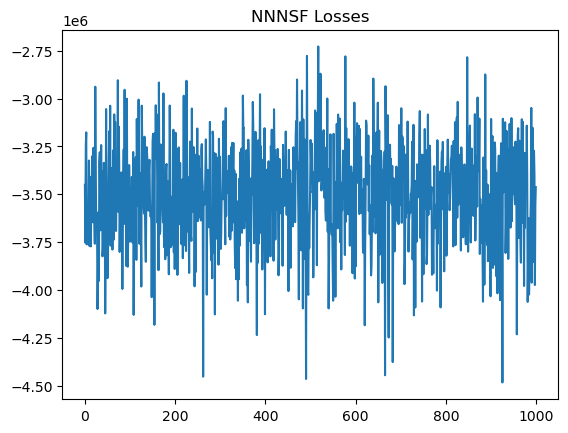

In [30]:
losses += more_losses
plt.plot(losses)
plt.title("NNNSF Losses")

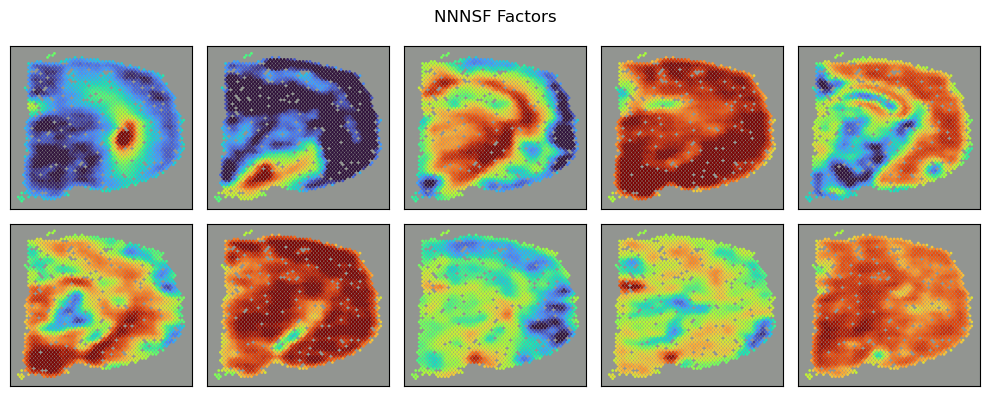

In [31]:
model.cpu()
qF, _, _ = model.prior(X_torch.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)

fig2.suptitle("NNNSF Factors")
fig2.tight_layout()

In [170]:
# 1. train mean and variance (spatial) until convergence  (6 hrs)
model.sf.prior.Lu.requires_grad=True
model.sf.prior.mu.requires_grad=True

model.cf.prior.mean.requires_grad=False
model.cf.prior.scale.requires_grad = False
model.sf.prior.kernel.lengthscale.requires_grad = False
model.sf.prior.kernel.sigma.requires_grad = False
model.sf.W.requires_grad=False
model.cf.W.requires_grad=False

In [171]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
model.to(device)
X_torch = X_torch.to(device)
more_losses, more_means, more_scales, idxs = putil.train_hybrid_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=100*360*2, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)

  0%|          | 0/72000 [00:00<?, ?it/s]


KeyboardInterrupt



Text(0.5, 1.0, 'NNNSF Losses')

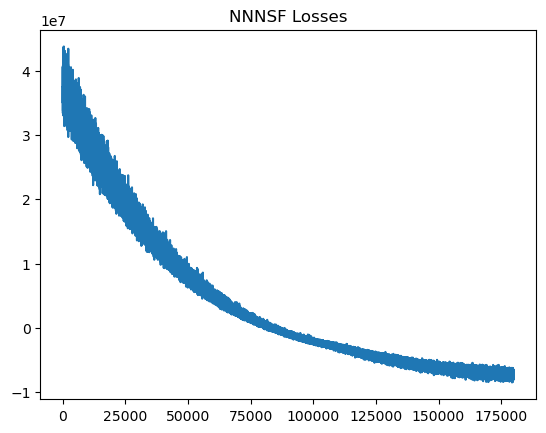

In [102]:
losses += more_losses
plt.plot(losses)
plt.title("NNNSF Losses")

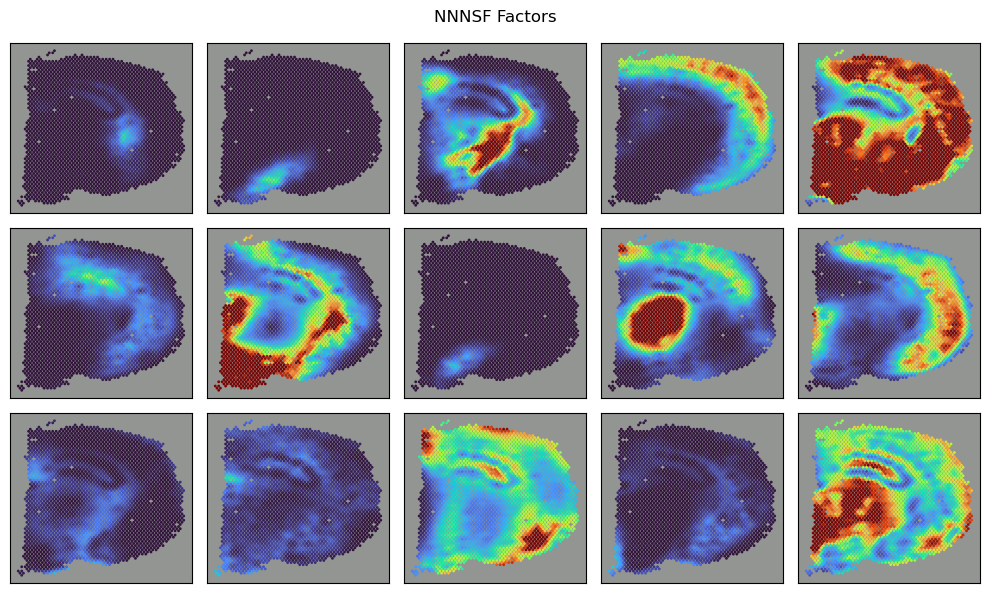

In [103]:
model.cpu()
qF, _, _ = model.sf.prior(X_torch.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)

fig2.suptitle("NNNSF Factors")
fig2.tight_layout()

In [104]:
# 2. train mean and variance until convergence + non-spatial variance (3 hrs)
model.sf.prior.Lu.requires_grad=True
model.sf.prior.mu.requires_grad=True
model.cf.prior.scale.requires_grad = True

model.cf.prior.mean.requires_grad=False
model.sf.prior.kernel.lengthscale.requires_grad = False
model.sf.prior.kernel.sigma.requires_grad = False
model.sf.W.requires_grad=False
model.cf.W.requires_grad=False

In [105]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
model.to(device)
X_torch = X_torch.to(device)
more_losses, more_means, more_scales, idxs = putil.train_hybrid_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=100*360, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)

  0%|          | 0/36000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'NNNSF Losses')

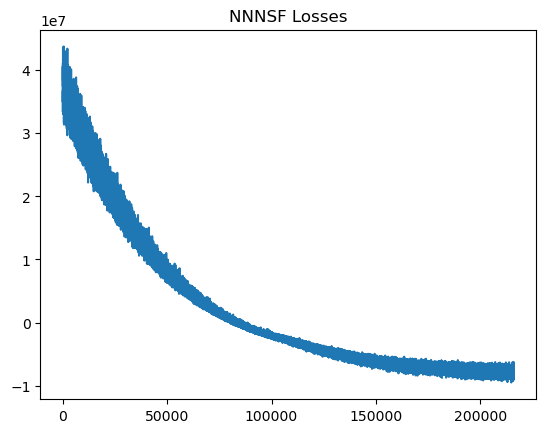

In [106]:
losses += more_losses
plt.plot(losses)
plt.title("NNNSF Losses")

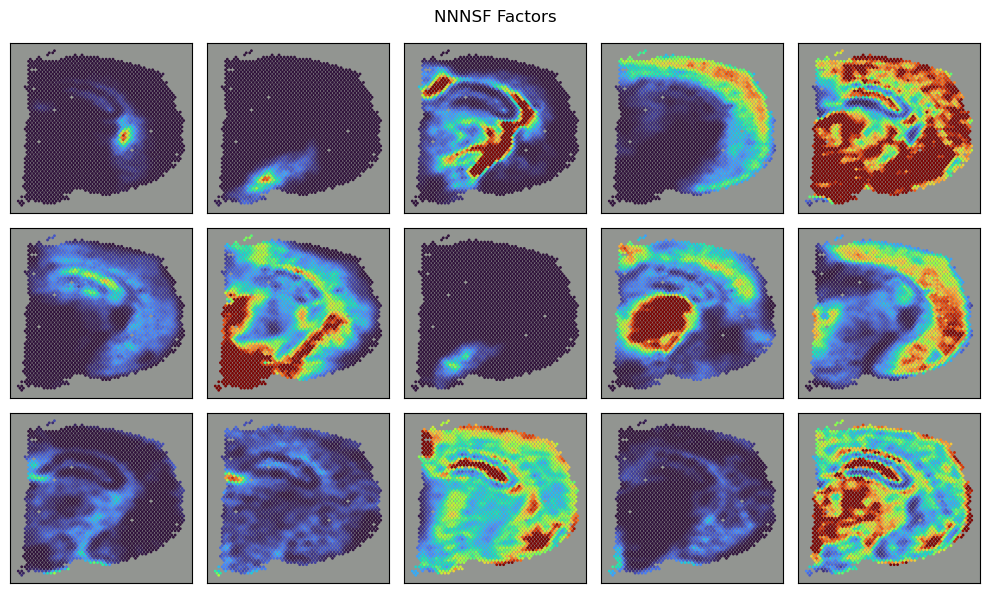

In [107]:
model.cpu()
qF, _, _ = model.sf.prior(X_torch.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)

fig2.suptitle("NNNSF Factors")
fig2.tight_layout()

In [108]:
# 3. train mean, variance and loadings spatial + non-spatial variance (6hrs)
model.sf.prior.Lu.requires_grad=True
model.sf.prior.mu.requires_grad=True
model.cf.prior.scale.requires_grad = True
model.sf.W.requires_grad=True

model.cf.prior.mean.requires_grad=False
model.sf.prior.kernel.lengthscale.requires_grad = False
model.sf.prior.kernel.sigma.requires_grad = False
model.cf.W.requires_grad=False

In [109]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
model.to(device)
X_torch = X_torch.to(device)
more_losses, more_means, more_scales, idxs = putil.train_hybrid_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=100*360*2, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)

  0%|          | 0/72000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'NNNSF Losses')

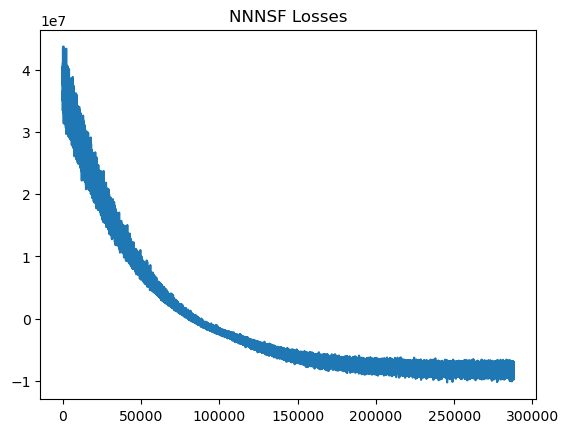

In [110]:
losses += more_losses
plt.plot(losses)
plt.title("NNNSF Losses")

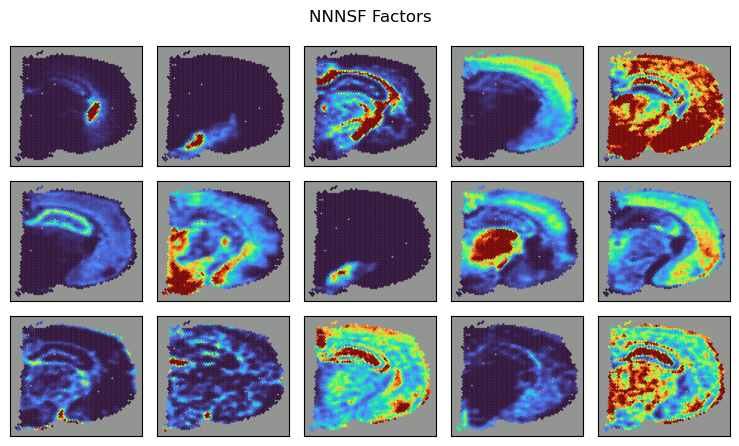

In [122]:
model.cpu()
qF, _, _ = model.sf.prior(X_torch.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=1.5, s=0.5, alpha=1, ax=None)

fig2.suptitle("NNNSF Factors")
fig2.tight_layout()

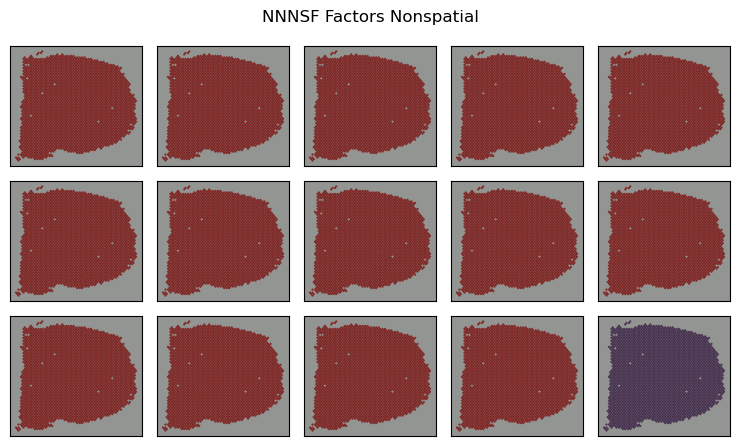

In [113]:
model.cpu()
qF, _, = model.cf.prior()
mean = torch.exp(qF.mean).detach()
fake_row = torch.zeros(1, 2688)
mean = torch.cat((mean, fake_row), dim=0)
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=1.5, s=0.4, alpha=0.7, ax=None)

fig2.suptitle("NNNSF Factors Nonspatial")
fig2.tight_layout()

In [123]:
# 4. train non-spatial mean, variance and loadings (6hrs)
model.cf.prior.mean.requires_grad=True
model.cf.prior.scale.requires_grad = True
model.cf.prior.scale.requires_grad = True
model.cf.W.requires_grad=True

model.sf.prior.Lu.requires_grad=False
model.sf.prior.mu.requires_grad=False
model.sf.W.requires_grad=False
model.sf.prior.kernel.lengthscale.requires_grad = False
model.sf.prior.kernel.sigma.requires_grad = False

In [128]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
model.to(device)
X_torch = X_torch.to(device)
more_losses, more_means, more_scales, idxs = putil.train_hybrid_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=100*360*2, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)

  0%|          | 0/36000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'NNNSF Losses')

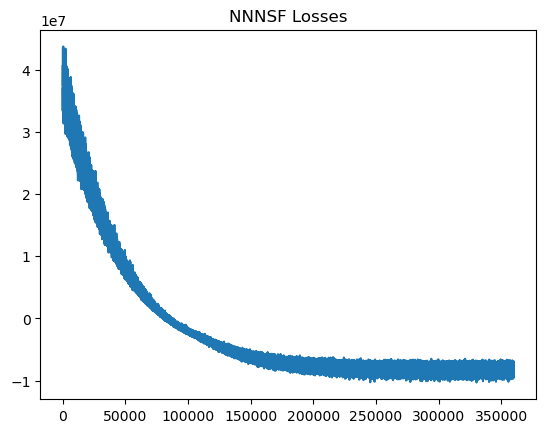

In [129]:
losses += more_losses
plt.plot(losses)
plt.title("NNNSF Losses")

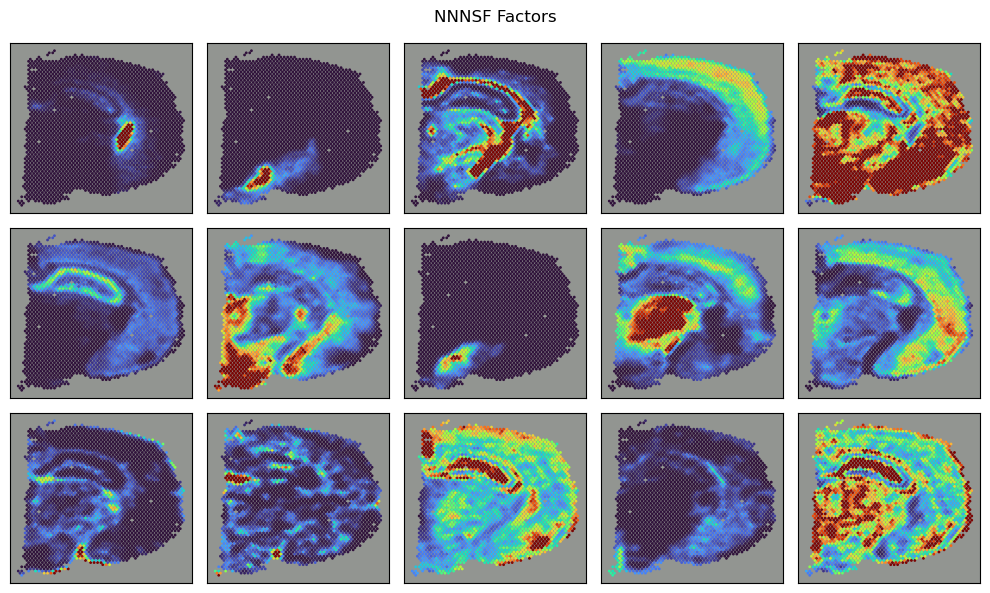

In [130]:
model.cpu()
qF, _, _ = model.sf.prior(X_torch.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)

fig2.suptitle("NNNSF Factors")
fig2.tight_layout()

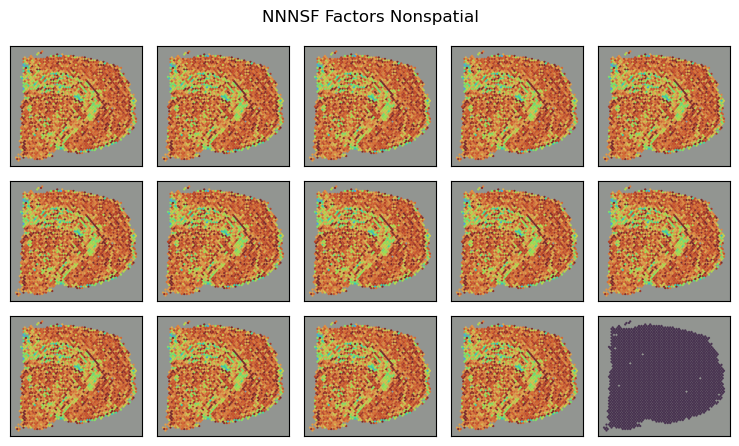

In [131]:
model.cpu()
qF, _, = model.cf.prior()
mean = torch.exp(qF.mean).detach()
fake_row = torch.zeros(1, 2688)
mean = torch.cat((mean, fake_row), dim=0)
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=1.5, s=0.4, alpha=0.7, ax=None)

fig2.suptitle("NNNSF Factors Nonspatial")
fig2.tight_layout()

In [132]:
# 5. train everything (6hrs)
model.cf.prior.mean.requires_grad=True
model.cf.prior.scale.requires_grad = True
model.cf.prior.scale.requires_grad = True
model.cf.W.requires_grad=True
model.sf.prior.Lu.requires_grad=True
model.sf.prior.mu.requires_grad=True
model.sf.W.requires_grad=True
model.sf.prior.kernel.lengthscale.requires_grad = False
model.sf.prior.kernel.sigma.requires_grad = False

In [133]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
model.to(device)
X_torch = X_torch.to(device)
more_losses, more_means, more_scales, idxs = putil.train_hybrid_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=100*360*2, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)

  0%|          | 0/72000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'NNNSF Losses')

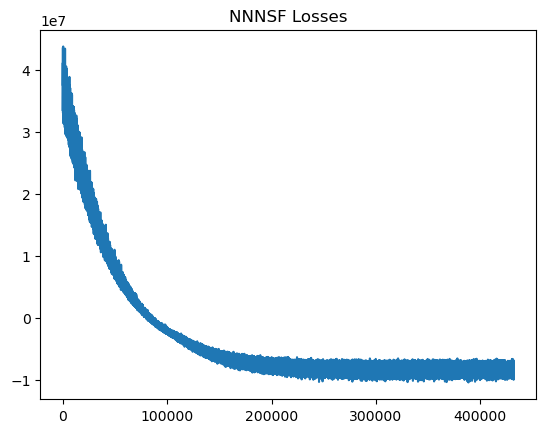

In [134]:
losses += more_losses
plt.plot(losses)
plt.title("NNNSF Losses")

In [135]:
X_torch.size()

torch.Size([2688, 2])

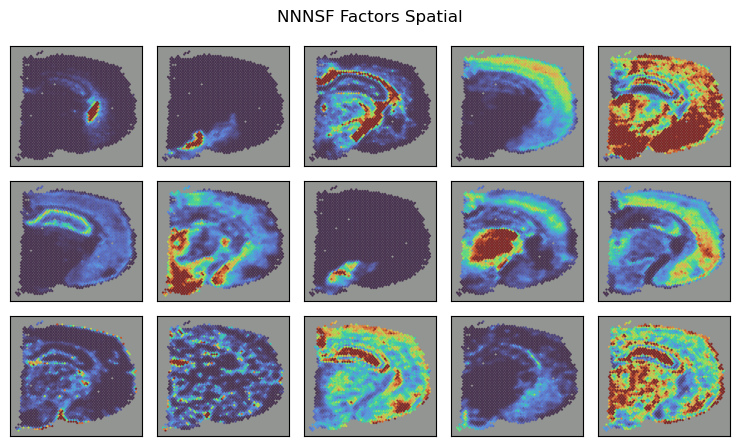

In [143]:
model.cpu()
qF, _, _ = model.sf.prior(X_torch.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(np.exp(mean), X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=1.5, s=0.4, alpha=0.7, ax=None)

fig2.suptitle("NNNSF Factors Spatial")
fig2.tight_layout()

In [137]:
qF

Normal(loc: torch.Size([15, 2688]), scale: torch.Size([15, 2688]))

In [138]:
qF

Normal(loc: torch.Size([15, 2688]), scale: torch.Size([15, 2688]))

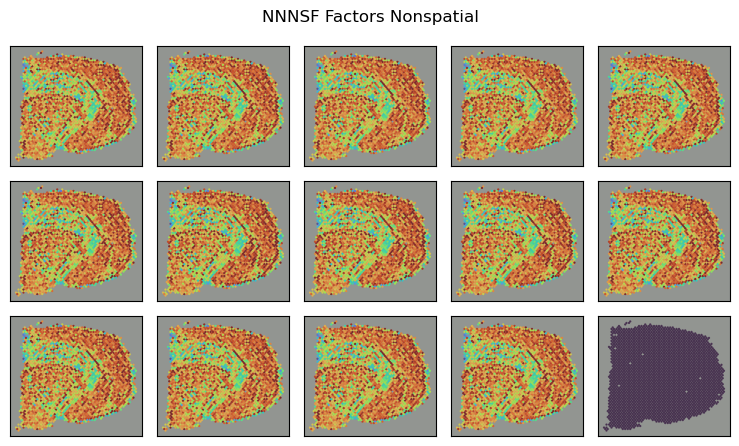

In [139]:
model.cpu()
qF, _, = model.cf.prior()
mean = torch.exp(qF.mean).detach()
fake_row = torch.zeros(1, 2688)
mean = torch.cat((mean, fake_row), dim=0)
if kwargs['L'] == 5:
    fig2, ax = putil.plot_factors_five(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=2, s=1, alpha=1, ax=None)
else:
    fig2, ax = putil.plot_factors(mean, X_torch.cpu().detach().numpy(), moran_idx=None, size=1.5, s=0.4, alpha=0.7, ax=None)

fig2.suptitle("NNNSF Factors Nonspatial")
fig2.tight_layout()

In [156]:
file_path = f"{kwargs['model']}_K={kwargs['K']}_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}_bs={kwargs['batch_size']}_NMFinit_state_dict.pth"
info_path = f"{kwargs['model']}_K={kwargs['K']}_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}_bs={kwargs['batch_size']}_NMFinit_model.pt"

In [157]:
model_state_path = path.join(save_path, file_path)
model_info_path = path.join(save_path, info_path)

In [158]:
torch.save(model.state_dict(), model_state_path)

In [159]:
torch.save({'losses': losses, 'means': means, 'scales': scales}, model_info_path)